04.03.2021

uses A07tv instead of A06tv: for the classification timeline use the index not the filename.

Because with the index, data is numerical and we can use an numpy array and do not need pandas.

To get the information on the filenames we will have to run through the validation set once more, in an additional for loop.

to dos:
* finalize visualization for classification timeline: coloured backgrounds in red or green according to error or correct classification at final epoch? Run ctl only till the chosen epoch when the model was saved? Do it not in the mean for the repetitions, but for a fixed model. 
* Compare oscillation / confidence in classification between different architectures.
* compare confidence with accuracy: When confident, is the classification (mostly) correct? When not confident, is the classification mostly incorrect? 
* Compare: Oscillation for different ethniities or (gender, ethnicity) combinations.

dones:
* Visualise: Show oscillation and Image side by side for images with correct classification vs misclassification.
* change documentation of ctl prom dict and pandas to numpy in A07tv.py
* visualize oscillation of classification for validation images , for all the independent repetitions in a single plot
* small multiple of oscillations for 20 validation images
* boxplots for variation of oscillation in the independent repetitions (repeated training and validation loops over full num_episodes: clearly not random. Result: Oscillation in classification can be used as an indicator on how confident the algorithm is about the classification.

In [15]:
!pwd

/home/jovyan/LFI/bainbridge_2k/code


In [16]:
main_dir = '/home/jovyan/LFI/bainbridge_2k/'

# location of original labels: LFI/bainbridge_2k/meta
label_file = '../meta/labels2k_A_train.csv'

images_train_dir = '../images_train/'
images_test_dir = '../images_test/'

!ls $images_train_dir | wc -l 
!ls $images_test_dir | wc -l # both numbers should add to 2222 - 14 (doublettes) = 2208

# to build PATH to save the best model
model_dir = 'myModels/best/'

docume_dir = 'myModels/documentation/' # base directory, will get a subdir matching the model ( model.get_name() )

2108
100


In [17]:
'''# not necessary to run this - these requirements are already satisfied
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install torch
!pip install torchvision'''

'# not necessary to run this - these requirements are already satisfied\n!pip install numpy\n!pip install pandas\n!pip install matplotlib\n!pip install torch\n!pip install torchvision'

In [18]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler

import torchvision
from torchvision import transforms, utils

import PIL

In [19]:
# plt.rcParams['figure.figsize'] = (10, 5)

In [20]:
def set_all_seeds(s): 
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(s)

    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(s)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(s)

    # 4. Set `pytorch` pseudo-random generator at a fixed value
    torch.manual_seed(s)

# define the model

In [21]:
from myModels import myModels as mm # mm = myModels
!pip install pytorch_model_summary
import pytorch_model_summary as pms

In [22]:
model = mm.MyNeuralNetwork3()

imgH, imgW = model.get_img_shape() # get the required image size for the model
# to be used in the transform of the Dataset

# order of imgH, imgW might be off. I have quadratic images so I don't care
print(pms.summary(model, torch.zeros((1, 3, imgH, imgW)), show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 3, 64, 64]             112             112
       MaxPool2d-2      [1, 4, 64, 64]               0               0
       Dropout2d-3      [1, 4, 31, 31]               0               0
          Linear-4           [1, 3844]           7,690           7,690
          Linear-5              [1, 2]               6               6
Total params: 7,808
Trainable params: 7,808
Non-trainable params: 0
-----------------------------------------------------------------------


In [23]:
docume_dir_named = docume_dir+model.get_model_name()+'/'
print(model.get_model_name())
!ls $docume_dir

MyNeuralNetwork3
MyNeuralNetwork1-01  MyNeuralNetwork3-03		 MyNeuralNetwork6
MyNeuralNetwork3     MyNeuralNetwork3-04		 MyNeuralNetwork6-01
MyNeuralNetwork3-01  MyNeuralNetwork3-05		 MyNeuralNetwork6-02
MyNeuralNetwork3-02  MyNeuralNetwork3_25training_epochs  MyNeuralNetwork6-03


if the directory already exist, it cannot be overwritten.

move the existing folder to a new name.

In [10]:
!mkdir $docume_dir_named

# Dataset and DataLoader for training (and val) set(s)

In [24]:
import A07tv as tv # train validate

In [25]:
df = pd.read_csv(label_file, index_col=0) 
df.index=range(df.shape[0])
setup = df[['Gender','Age','Race','newFilename']].copy()

# transform , no normalizing
transform = transforms.Compose([
    transforms.Resize((imgH,imgW)), # imgH, imgW as required for model
    transforms.ToTensor()
])

trainset = tv.TrainSet(setup=setup , transform=transform)

train_loader, val_loader = tv.loaders(trainset, setup) # batch_size=10, split=100 as defaults

In [26]:
len(val_loader.dataset) , len(train_loader.dataset)

(100, 2008)

## Train and validate

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("torch.cuda.is_available(): ", torch.cuda.is_available())

torch.cuda.is_available():  True


In [39]:
from copy import deepcopy

## model setup
# variable model holds the model defined in first paragraph.
model = model.to(device) # pushing to device before passing it ti training() and validate() functions

learning_rate = 0.001
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

print('**', model)

num_epochs = 40 # 150 when things run smoothly
C=2 # number of classes
T=6 # loops for statistical evaluation

good_seeds = [1,2,3,8,11,12] # for model 3 it happens that the model does not learn.
# we avoid these (bad) seeds.

for t in range(T):
    print('Repetition {}/{}'.format(t, T - 1))
    print('+' * 20)
    
    best_acc = 0.0
    stop_epoch = 0 
    
    seed_value = good_seeds[t]
    #seed_value = t
    set_all_seeds(seed_value)
    
    for name, module in model.named_children():
        if hasattr(module, 'reset_parameters'):
            #print('resetting ', name)
            module.reset_parameters()
    
    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # train
        training_loss, training_acc = tv.training(model, train_loader, optimizer, criterion, device)
       
        # validation
        val_loss , val_cf_m , ctl_epoch, g_by_e, f1 = tv.validate(model, val_loader, criterion, device)
        # print('received from tv.validate : ' , ctl_epoch)
     
        tn, fp, fn, tp = val_cf_m.ravel()
        val_acc = (tp+tn)/len(val_loader.dataset)
               
        # overall best model
        if epoch > 29:
            if val_acc > 0.9:
                best_acc = val_acc
                stop_epoch = epoch
                best_model_wts = deepcopy(model.state_dict())
                print('deepcopy state dict at epoch {} with acc {} with seed {}'.format(epoch, best_acc, good_seeds[t]))
            # docume_best_model just for surveillance. We only need best_model_wts
            # best_model_wts has length of 10, so I put it in a list. 
            # to extract it, use docume_best_model['state_dict'][0]
            # docume_best_model = docume_best_model.append(pd.DataFrame({'t':t,'epoch':epoch,'val acc':val_acc,'state_dict':[best_model_wts]}), ignore_index=True)
          
        ## end of train val epoch , go up to loop again or
    ## finish the train val epochs
    ## and document
        
    print(f'Best acc in validation: {best_acc:4f}')

    # save the best model for final evaluation on test data
    PATH = model_dir+'{}_seed{}_acc{}_epoch{}.pt'.format(model.get_model_name(), good_seeds[t], int(10000*best_acc), stop_epoch)
    torch.save(best_model_wts, PATH )

** MyNeuralNetwork3(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=3844, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=2, bias=True)
)
Repetition 0/5
++++++++++++++++++++
Epoch 0/39
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.6751 Acc: 0.5647

Validation Batch:    0 of 10
----------
validation Loss: 0.6544 Acc: 0.5700

Epoch 1/39
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.6295 Acc: 0.5951

Validation Batch:    0 of 10
----------
validation Loss: 0.6294 Acc: 0.7600

Epoch 2/39
----------
Training Batch:    0 o

Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2380 Acc: 0.9084

Validation Batch:    0 of 10
----------
validation Loss: 0.2660 Acc: 0.8900

Epoch 28/39
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2345 Acc: 0.9128

Validation Batch:    0 of 10
----------
validation Loss: 0.3509 Acc: 0.8700

Epoch 29/39
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2535 Acc: 0.8984

Validation Batch:    0 of 10
----------
validation Loss: 0.2676 Acc: 0.8800

Epoch 30/39
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2406 Acc: 0.9079

Validation Batch:    0 of 10
----------


Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.3389 Acc: 0.8561

Validation Batch:    0 of 10
----------
validation Loss: 0.2954 Acc: 0.8500

Epoch 17/39
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.3248 Acc: 0.8750

Validation Batch:    0 of 10
----------
validation Loss: 0.3028 Acc: 0.8500

Epoch 18/39
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.3204 Acc: 0.8650

Validation Batch:    0 of 10
----------
validation Loss: 0.2842 Acc: 0.8700

Epoch 19/39
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.30

Training Batch:  200 of 201
----------
Training Loss: 0.5240 Acc: 0.7694

Validation Batch:    0 of 10
----------
validation Loss: 0.5345 Acc: 0.7800

Epoch 4/39
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.4989 Acc: 0.7834

Validation Batch:    0 of 10
----------
validation Loss: 0.4967 Acc: 0.7700

Epoch 5/39
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.4554 Acc: 0.8132

Validation Batch:    0 of 10
----------
validation Loss: 0.4612 Acc: 0.8200

Epoch 6/39
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.4417 Acc: 0.8157

Validation Batch:    0 of 10
----------
validation Loss: 0.4313 Acc: 0.

Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2078 Acc: 0.9223

Validation Batch:    0 of 10
----------
validation Loss: 0.2545 Acc: 0.9000

Epoch 33/39
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2154 Acc: 0.9163

Validation Batch:    0 of 10
----------
validation Loss: 0.2142 Acc: 0.8900

Epoch 34/39
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2022 Acc: 0.9313

Validation Batch:    0 of 10
----------
validation Loss: 0.2748 Acc: 0.9000

Epoch 35/39
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.20

Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.4018 Acc: 0.8337

Validation Batch:    0 of 10
----------
validation Loss: 0.4253 Acc: 0.7800

Epoch 22/39
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.3671 Acc: 0.8471

Validation Batch:    0 of 10
----------
validation Loss: 0.3812 Acc: 0.8300

Epoch 23/39
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.3533 Acc: 0.8541

Validation Batch:    0 of 10
----------
validation Loss: 0.3496 Acc: 0.8400

Epoch 24/39
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.34

validation Loss: 0.5187 Acc: 0.7700

Epoch 10/39
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.4708 Acc: 0.8043

Validation Batch:    0 of 10
----------
validation Loss: 0.4812 Acc: 0.8100

Epoch 11/39
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.4457 Acc: 0.8157

Validation Batch:    0 of 10
----------
validation Loss: 0.4565 Acc: 0.8400

Epoch 12/39
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.4230 Acc: 0.8252

Validation Batch:    0 of 10
----------
validation Loss: 0.4112 Acc: 0.8400

Epoch 13/39
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 20

Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2106 Acc: 0.9193

Validation Batch:    0 of 10
----------
validation Loss: 0.2365 Acc: 0.9000

Epoch 39/39
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2234 Acc: 0.9104

Validation Batch:    0 of 10
----------
validation Loss: 0.2189 Acc: 0.9200

deepcopy state dict at epoch 39 with acc 0.92 with seed 11
Best acc in validation: 0.920000
Repetition 5/5
++++++++++++++++++++
Epoch 0/39
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.7313 Acc: 0.4950

Validation Batch:    0 of 10
----------
validation Loss: 0.6783 Acc: 0.5700

Epoch 1/39
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch: 

Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2888 Acc: 0.8810

Validation Batch:    0 of 10
----------
validation Loss: 0.2646 Acc: 0.8800

Epoch 28/39
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2813 Acc: 0.8840

Validation Batch:    0 of 10
----------
validation Loss: 0.2574 Acc: 0.9200

Epoch 29/39
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2750 Acc: 0.8845

Validation Batch:    0 of 10
----------
validation Loss: 0.2727 Acc: 0.9000

Epoch 30/39
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.26

In [38]:
len(best_model_wts)

6

In [ ]:
# what exactly do we get from the validation(...) call?
e,c,p,r,f = tv.validate(model, val_loader, criterion, device) 
# returns epoch_loss, cf_m, pred_dict, recall_by_e
print('epoch loss : ' , e ,'\n')
print('confusion matrix :\n ' , pd.DataFrame(c), '\n')
print('array of predictions:\n' , p,'\n')
print('recall by ethnicity, correct: \n' , pd.DataFrame(r[0,:,:]),'\n')
print('recall by ethnicity, misclassified: \n' , pd.DataFrame(r[1,:,:]))

note that values in the confusion matrix can be obtained from the later recall by ethnicity matrix.

Also check that this is correckt in this special case. the columns in the e matrix sum to the entries in the confusion matrix.

In [16]:
# docume_error documents the error for T trainings, over num_epochs for both (C=2) classes
print('shape : ' , docume_error.shape) # T, C, num_epochs
m1 = docume_error.mean(axis=2) # mean over the epochs
m2 = docume_error.mean(axis=2).mean(axis=0) # overall mean error for the classes
print(m1.shape , m2.shape)
print(m1)
print(m2)

shape :  (5, 2, 15)
(5, 2) (2,)
[[ 0.         43.        ]
 [ 5.6        11.93333333]
 [15.33333333 11.2       ]
 [ 8.33333333 10.86666667]
 [ 0.         43.        ]]
[ 5.85333333 24.        ]


# metrics
## loss and accuracy

Plot loss and accuracy for each repetition.

In [14]:
# plots only the last loop : t=T
'''plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='train loss')
plt.plot(val_loss_history, label='validation loss')
plt.xlabel('epoch')
plt.title('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='train acc')
plt.plot(val_acc_history, label='validation acc')
plt.xlabel('epoch')
plt.title('accuracy')
plt.legend()
plt.show()'''

"plt.subplot(1, 2, 1)\nplt.plot(train_loss_history, label='train loss')\nplt.plot(val_loss_history, label='validation loss')\nplt.xlabel('epoch')\nplt.title('loss')\nplt.legend()\n\nplt.subplot(1, 2, 2)\nplt.plot(train_acc_history, label='train acc')\nplt.plot(val_acc_history, label='validation acc')\nplt.xlabel('epoch')\nplt.title('accuracy')\nplt.legend()\nplt.show()"

In [17]:
def plot_mat2d (mat_2d, set_title=None):
    if set_title is not None:
        assert type(set_title)==list, str(type(set_title))+' set_title should be a list of titles (str) for the subplots'
        assert len(set_title)==2 , 'need 2 titles for 2 subplots.'
    
    plt.figure(figsize=(12,4))
    
    plt.subplot(1, 2, 1)
    plt.plot(mat_2d[0,:], label='train loss')
    plt.plot(mat_2d[1,:], label='validation loss')
    plt.plot([0,num_epochs], [0.2,0.2], color='black', linewidth=0.7, linestyle = 'dotted')
    plt.xlabel('epoch')
    if set_title is None:
        plt.title('loss')
    else:
        plt.title(set_title[0])
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(mat_2d[2,:], label='train acc')
    plt.plot(mat_2d[3,:], label='validation acc')
    plt.plot([0,num_epochs], [0.9,0.9], color='black', linewidth=0.7, linestyle = 'dotted')
    plt.xlabel('epoch')
    if set_title is None:
        plt.title('accuracy')
    else:
        plt.title(set_title[1])
    plt.legend()
    plt.savefig(docume_dir_named+'loss_acc'+str(t)+'.png')
    plt.show()

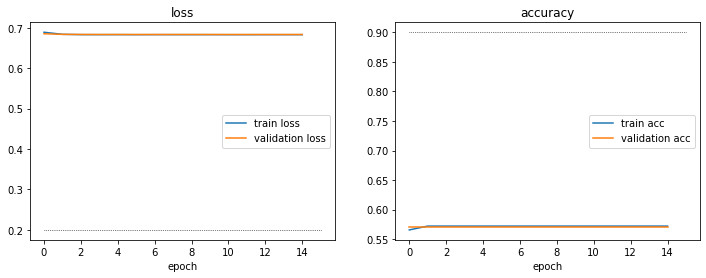

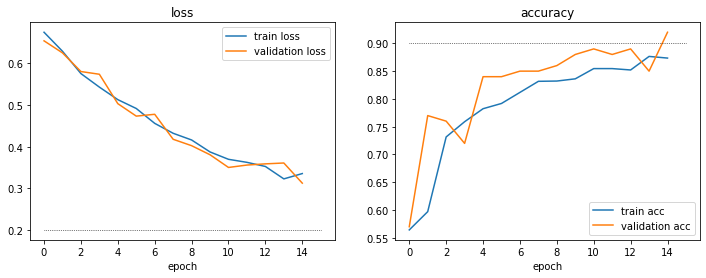

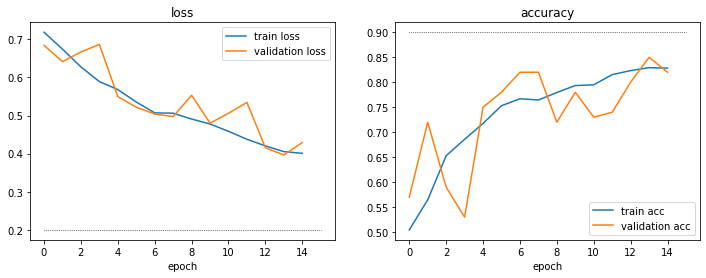

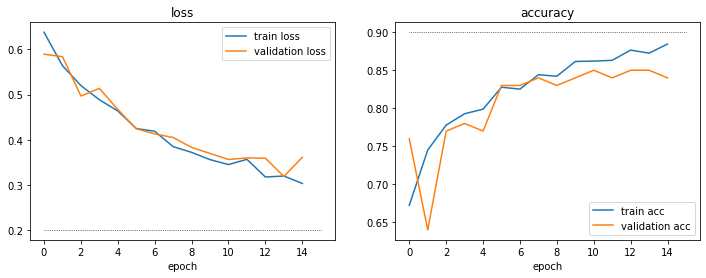

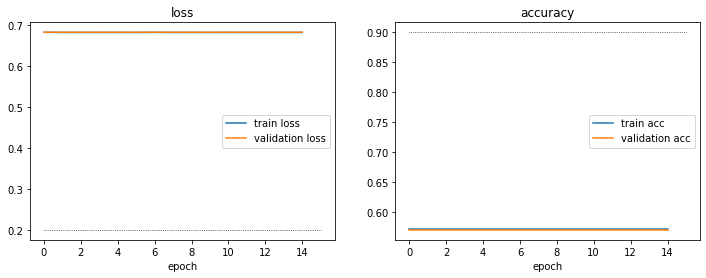

In [18]:
for t in range(T):
# for t in range(1,T-1):
    plot_mat2d(docume_tvla[t,:,:])

For T=5 the model did  not learn anything in 2 repetitions. The architecture completely failed 40% of the time!

For T=10 the model did not learn anything in 4 repetitions. The architecture completely failed 40% of the time!
That is bad but it can be avoided :-) by just starting again with another seed.

We continue to work with only the training validation loops / repetitions when the model did learn something.

In [15]:
# remove repetitions (of independent train val loops) when the model did not lern anything

print('before : ' , docume_error.shape)
if docume_error.shape[0]==T: 
    if T==5:
        # use only repetitions when the network did learn something
        docume_error = docume_error[1:T-1,:,:]
        docume_tvla = docume_tvla[1:T-1,:,:]
        docume_f1 = docume_f1[1:T-1,:]
        docume_ge = docume_ge[1:T-1,:,:,:]
        docume_ctl = docume_ctl[1:T-1,:,:]
    elif T==10: # repetitions when model does not learn: 0,5,6,7
        docume_error = docume_error[(1,2,3,4,8,9),:,:] # this is not slicing?!
        docume_tvla = docume_tvla[(1,2,3,4,8,9),:,:]
        docume_f1 = docume_f1[(1,2,3,4,8,9),:]
        docume_ge = docume_ge[(1,2,3,4,8,9),:,:,:]
        docume_ctl = docume_ctl[(1,2,3,4,8,9),:,:]
else:
    print('check if repetitions have been removed correctly / before.')
print('after : ' , docume_error.shape)

before :  (5, 2, 15)
after :  (3, 2, 15)


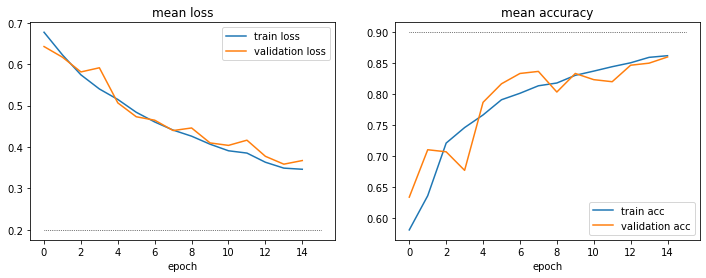

<Figure size 432x288 with 0 Axes>

In [20]:
plot_mat2d(docume_tvla.mean(axis=0), set_title=['mean loss', 'mean accuracy'])
plt.savefig(docume_dir_named+'loss_acc_mean.png')
plt.show()

## result from loss acc plots

### bias variance trade-off, early stopping

The mean of the training set accuracy (mean over the repetitions where the model actually does learn) rises to 90% after around 25 epochs, gets to almost 95% after 50 trining epochs. This indicates that the model can well differentiate b/w the given labels. There is no (heavy) bias problem.

The training loss continuously declines, which is good.

Since the validation (same mean as before) mean accuracy stays below 90% we have some variance remaining in our model / data set. The validation loss never reaches 0.2, it stops declining after about 30 epochs. 

The performance of this model is limited but not bad for my purpose.

The model should be trained around 25 to 30 epochs. After that overfitting starts.

In [16]:
est_early_stop_time = num_epochs

### other stuff

The model from repetition t=2 gets the best validation results in acc and loss. However, this is probably due to a good match to the valation set. So it is a way of overfitting the validation set which will not help with the test set.

The mean accuracy tells me we can expect an accuracy on the test set of about 90%. Since the test set is itself random we would like to get a conf intervall. We could obtain this from the dev sets, maybe with more repetitions, i.e. a larger T.

Also it would be nice to have an automatic vis of the confInt...

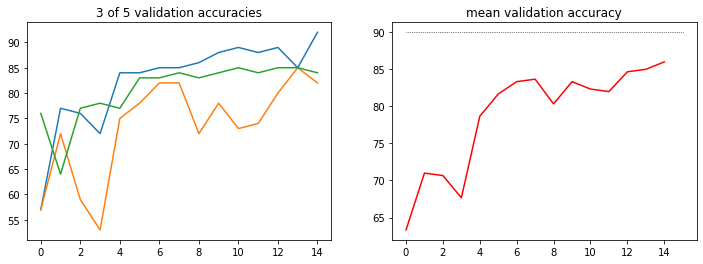

In [21]:
# for more than 3 lines (T>3) it is better to plot the mean in a separate coord system 
# accuracy timeline : 100 - misclassified = 100 - fp - fn
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot((100-docume_error.sum(axis=1)).T, label=range(2))
plt.title(str(docume_error.shape[0])+' of '+str(T)+' validation accuracies')
plt.subplot(1,2,2)
plt.plot(np.mean((100-docume_error.sum(axis=1)).T,axis=1), label='mean', color='red')
plt.plot([0,num_epochs], [90,90], color='black', linewidth=0.7, linestyle = 'dotted')
plt.title('mean validation accuracy')

plt.savefig(docume_dir_named+'accuracies.png')
plt.show()

## f1 score, not weighted (anymore, changed it in tv.validate)
Since I don't really know what weighted means, I should not use it.

(3, 10)


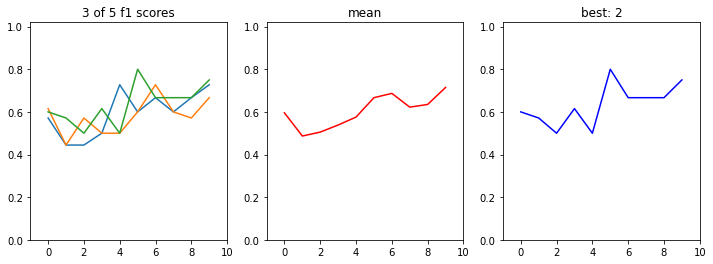

In [34]:
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.plot(docume_f1.T)
plt.axis((-1,num_epochs,0,1.02))
plt.title(str(docume_error.shape[0])+' of '+str(T)+' f1 scores')
############################################
plt.subplot(1,3,2)
#plt.plot(docume_f1.T)
plt.plot(np.mean(docume_f1.T,axis=1), label='mean', color='red')
#plt.plot([0,num_epochs], [90,90], color='black', linewidth=0.7, linestyle = 'dotted')
plt.axis((-1,num_epochs,0,1.02))
plt.title('mean')
#############################################
plt.subplot(1,3,3)
print(docume_f1.shape)
#  print(np.argmax(docume_f1,axis=0))
best_in_rep = np.argmax(docume_f1,axis=1)
best = np.argmax([docume_f1[idx,best_in_rep[idx]] for idx in range(len(best_in_rep))])
#plt.plot(docume_f1.T)
plt.plot(docume_f1[best,:], color='blue')
plt.axis((-1,num_epochs,0,1.02))
#plt.plot([0,num_epochs], [90,90], color='black', linewidth=0.7, linestyle = 'dotted')
plt.title('best: '+str(best))
plt.savefig(docume_dir_named+'f1.png')
plt.show()



## error analysis by gender
with respect to the labeled genders. Up to now we looked into loss and accuracy for the train and dev set, ot differentiating b/w the labels of the images. Now we want to look into how each gender performs.

### Mean confusion matrix at estimated stopping epoch

In [ ]:
cfm= pd.DataFrame([docume_ge[:,:,:,0,est_early_stop_time].mean(axis=0).sum(axis=1),
docume_ge[:,:,:,1,est_early_stop_time].mean(axis=0).sum(axis=1)[::-1]], columns=['classif f','classif m'], index=['label f','label m'])
cfm
# docume_ge[:,:,:,0,est_early_stop_time].mean(axis=0).sum(axis=1) # labeled female

In [ ]:
docume_f1[:,est_early_stop_time].mean()
#docume_f1.shape

[[ 1  7]
 [15  3]
 [ 7  9]]


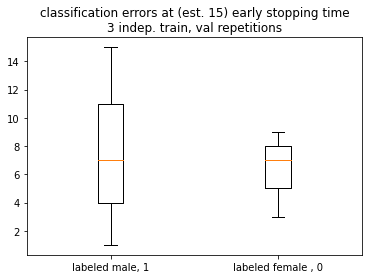

In [27]:
# data = docume_error[:,:,num_epochs-1] # error at final classification
data = docume_error[:,:,est_early_stop_time-1] # error at early stopping time
print(data)
fig, ax = plt.subplots()
ax.boxplot(data, showmeans=True , labels=['labeled male, 1','labeled female , 0'])
#plt.legend(['fp','fn'])
plt.title('classification errors at (est. {}) early stopping time\n{} indep. train, val repetitions'.format(est_early_stop_time, data.shape[0]))
plt.savefig(docume_dir_named+'boxplot_error.png')
plt.show()

### error timeline by gender

In [22]:
def print_errors_by_label (docume):
    T = docume.shape[0]
    #print(plt.figure.params)
    if T < 4:
        plt.figure(figsize=(4*T,4))
    elif T <7:
        plt.figure(figsize=(4*(T//2+1),8))
    #eps = docume.shape[2] # num_epochs
    #T = docume.shape[0]
    # to set a uniform y axis, find the max value in 3rd for all t<=T and c<=C
    y_max = max(docume.max(axis=2).ravel())
    #print(y_max)
    
    for t in range(T):
        if T<4:
            plt.subplot(1, T, 1+t)
        elif T<7:
            plt.subplot(2, (T+1)//2, 1+t)
        plt.axis((-0.5,num_epochs,-0.5,y_max+0.5))
        plt.plot(docume[t,1,:], label='labeled female, fp')
        plt.plot(docume[t,0,:], label='labeled male, fn')
        plt.xlabel('epoch')
        #plt.ylabel('nr. missclassified')
        #plt.title('Types of missclassification')
        plt.legend()
    plt.savefig(docume_dir_named+'ctl_error.png')
# docume[t,0,0:num_epochs] = val_fn_history

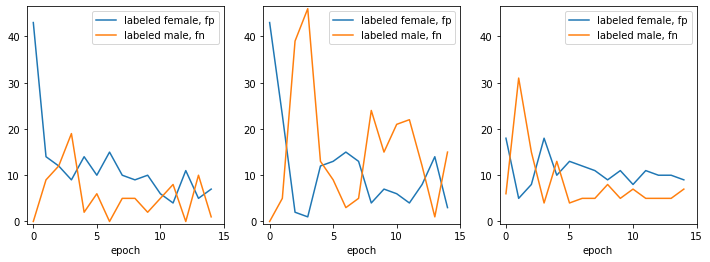

In [23]:
print_errors_by_label(docume_error)

In some runs, in absolute numbers the classification errors for labeled female and labeled male were about the same. This implies a higher proportion of missclassifications in females when compared to males.

But this is what will often happen when you go for few misclassifications. It basically does not matter whom you misclassify. Relative misclassification will always put the dominant class in the better position.

However, in this run (with seeds at 2 stages: when splitting into train/val sets and when running the training (important for random initilisation, say) labeled females were misclassified more often than males, though they amount for less than hals of the validation data. 

We have spotted an aspect of unfairness.

We should check that this is statistically significant.

How labeled females have a higher (absolute) error rate than males. This gets worse when we look into the relative error for the classes since there are more images labeled male in the data set (stratified split, so this holds for the training and validation set).

(2, 15)


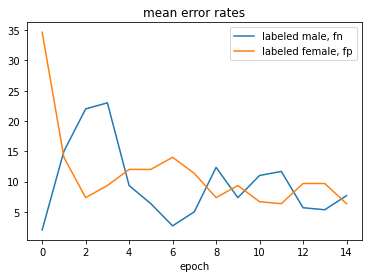

In [24]:
# errors for the classes , recall for labeled female and labeled male
ctl_mean = docume_error.mean(axis=0)
print(ctl_mean.shape)
plt.subplot(1, 1, 1)
plt.plot(ctl_mean.T)
plt.xlabel('epoch')
plt.legend(['labeled male, fn','labeled female, fp'])
plt.title('mean error rates')
plt.savefig(docume_dir_named+'ctl_error_mean.png')

We look at the error at the estimated stopping time. A box plot allows for easy observation of statistical significance (no test needed ...):

It should be noted that the disparity / difference b/w the genders gets more significant / gets worse / oscillates less as the model overfits the training data. This shows a clear trend.

Around the estimated early stopping time after 25 epochs, the boxplot shows a significant (as meets the eye, though I should have more independent repetitions) difference for the classification errors of ach gender group.

## error analysis by gender and ethnicity
during training we documented errors with respect to gender and ethnicity for the dev set. Now we want to look into how each gender and ethnicity combination performed.

In [68]:
'''a = docume_ge[:,:,:,:,num_epochs-1].mean(axis=0) # final epoch, mean over T-1 repetitions
# fine tuning by hand: excluding repetition with constant accuracy: repetition t=0
#a = docume_ge[:,:,:,:,num_epochs-1][1:5].mean(axis=0) # final epoch, mean over T-1 repetitions
data = np.concatenate([a[0,:,:], a[1,:,:]], axis=1)
df= pd.DataFrame(data, index=range(7), columns=['f correct','m correct','f miscl','m miscl'])
print('gender ethnicity documentation over epochs is reuced:\nmean over repetitions, only final epoch.\n')
print('7 sparcly populated ethnic categories\n')
print(df)
print('\nadd ethnic categories 3,4,5,6: 2 asian, 1 latin and 1 other category.')
data= np.concatenate([data[0:3,:] , [np.sum(data[3:7,:],axis=0)]], axis=0)
df= pd.DataFrame(data, index=range(4), columns=['f correct','m correct','f miscl','m miscl'])
print(df)
print('\nadd column for totals and percentage')
df['f totals'] = df['f correct']+df['f miscl']
df['m totals'] = df['m correct']+df['m miscl']
#df['f error %']= round(100*df['f miscl']/(df['f correct']+df['f miscl']),1)
#df['m error %']= round(100*df['m miscl']/(df['m correct']+df['m miscl']),1)
df['f recall %']= round(100*df['f correct']/(df['f correct']+df['f miscl']),1)
df['m recall %']= round(100*df['m correct']/(df['m correct']+df['m miscl']),1)
df'''

"a = docume_ge[:,:,:,:,num_epochs-1].mean(axis=0) # final epoch, mean over T-1 repetitions\n# fine tuning by hand: excluding repetition with constant accuracy: repetition t=0\n#a = docume_ge[:,:,:,:,num_epochs-1][1:5].mean(axis=0) # final epoch, mean over T-1 repetitions\ndata = np.concatenate([a[0,:,:], a[1,:,:]], axis=1)\ndf= pd.DataFrame(data, index=range(7), columns=['f correct','m correct','f miscl','m miscl'])\nprint('gender ethnicity documentation over epochs is reuced:\nmean over repetitions, only final epoch.\n')\nprint('7 sparcly populated ethnic categories\n')\nprint(df)\nprint('\nadd ethnic categories 3,4,5,6: 2 asian, 1 latin and 1 other category.')\ndata= np.concatenate([data[0:3,:] , [np.sum(data[3:7,:],axis=0)]], axis=0)\ndf= pd.DataFrame(data, index=range(4), columns=['f correct','m correct','f miscl','m miscl'])\nprint(df)\nprint('\nadd column for totals and percentage')\ndf['f totals'] = df['f correct']+df['f miscl']\ndf['m totals'] = df['m correct']+df['m miscl']\n#

In [69]:
'''df.shape
# labels on x axis should be ['undef','white','black','other']
# df[['f miscl %','m miscl %']].plot.bar(\
df[['f recall %','m recall %']].plot.bar(\
    xticks=[0,1,2,3], \
    #xlabel= ['undef','white','black','other'] , \
    legend= True, \
    title='recall for gender grouped by ethnicity on validation set\nmean values over {} repetitions after {} training epochs'.format(T,num_epochs))
#df#.plot.bar()
plt.savefig(docume_dir_named+'recall_grouped_by_ethnicity.png')'''

"df.shape\n# labels on x axis should be ['undef','white','black','other']\n# df[['f miscl %','m miscl %']].plot.bar(df[['f recall %','m recall %']].plot.bar(    xticks=[0,1,2,3],     #xlabel= ['undef','white','black','other'] ,     legend= True,     title='recall for gender grouped by ethnicity on validation set\nmean values over {} repetitions after {} training epochs'.format(T,num_epochs))\n#df#.plot.bar()\nplt.savefig(docume_dir_named+'recall_grouped_by_ethnicity.png')"

In [31]:
#print(docume_ge.shape)
a = docume_ge[:,:,:,:,est_early_stop_time-1].mean(axis=0) 

# data reduction: fixed epoch at estimated stopping time
# Check, if this is reproduced 
# or changed when changing the seeds for the repetitions

data = np.concatenate([a[0,1:,:], a[1,1:,:]], axis=1) # exclude ethnicity 0
print(data)
df= pd.DataFrame(data, index=range(6), columns=['f correct','m correct','f miscl','m miscl'])
print('gender ethnicity documentation over epochs is reuced:\nmean over repetitions, only estimated early stopping epoch.\n')
print('6 sparcly populated ethnic categories\n')
print(df)
print('\nadd ethnic categories 2,3,4,5: 2 asian, 1 latin and 1 other category.')

data= np.concatenate([data[0:2,:] , [np.sum(data[2:6,:],axis=0)]], axis=0)
#print(data)
#print('****')
df= pd.DataFrame(data, index=['white','black','other'], columns=['f correct','m correct','f miscl','m miscl'])
print(df)
print('\nadd column for totals and percentage')
df['f totals'] = df['f correct']+df['f miscl']
df['m totals'] = df['m correct']+df['m miscl']
df['f error %']= round(100*df['f miscl']/(df['f correct']+df['f miscl']),1)
df['m error %']= round(100*df['m miscl']/(df['m correct']+df['m miscl']),1)

# labels on x axis should be ['undef','white','black','other']
df[['f error %','m error %']].plot.bar(\
    rot = 1, \
    legend= True, \
    title='rel. error for gender ethnicity combinations on validation set\nmean values over {} repetitions after {} training epochs'.format(docume_ge.shape[0],est_early_stop_time))
#df#.plot.bar()
plt.savefig(docume_dir_named+'error_rates_grouped_by_ethnicity.png')

gender ethnicity documentation over epochs is reuced:
mean over repetitions, only estimated early stopping epoch.

7 sparcly populated ethnic categories

   f correct  m correct   f miscl  m miscl
0   0.000000        0.0  0.000000      0.0
1  30.166667       44.5  5.833333      2.5
2   1.666667        6.0  2.333333      0.0
3   1.166667        1.0  0.833333      0.0
4   0.000000        0.0  0.000000      0.0
5   1.000000        2.0  0.000000      0.0
6   0.000000        1.0  0.000000      0.0

add ethnic categories 3,4,5,6: 2 asian, 1 latin and 1 other category.


ValueError: Shape of passed values is (4, 4), indices imply (3, 4)

In [117]:
'''model.eval()
class_correct = list(0 for i in range(2))
class_total = list(0 for i in range(2))
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        labels = labels['gender'].to(device)
        images = images.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(2):
    print('Accuracy of %2s : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))'''

"model.eval()\nclass_correct = list(0 for i in range(2))\nclass_total = list(0 for i in range(2))\nwith torch.no_grad():\n    for data in val_loader:\n        images, labels = data\n        labels = labels['gender'].to(device)\n        images = images.to(device)\n        \n        outputs = model(images)\n        _, predicted = torch.max(outputs, 1)\n        \n        c = (predicted == labels).squeeze()\n        for i in range(batch_size):\n            label = labels[i]\n            class_correct[label] += c[i].item()\n            class_total[label] += 1\n\nfor i in range(2):\n    print('Accuracy of %2s : %2d %%' % (\n        i, 100 * class_correct[i] / class_total[i]))"

## documentation of classification errors during training process
only for the validation images. I have to make sure I am accessing the validation images and can identify each image. I need to know how the classification of each image changes over time. This is why I use a dictionary with the key equal to the filename.

Create an time series for each test image. 

# classification timeline
We first look into a single classification timeline, ctl is equal to docume_ctl[T-1,:,:], the ctl in the last repetition loop. ctl is a pandas DataFrame.

ctl is the classification timeline. The images in the validation set are the columns, each row contains information on how this image was classified in each epoch. ctl has num-epochs many rows

In [29]:
print('ctl.shape : ' , ctl.shape)
# print('ctl.columns : ' , list(ctl.columns)[0:5])
type(ctl)
print(ctl.shape)
ctl[0,:,:]

ctl.shape :  (100, 2, 15)
(100, 2, 15)


array([[777, 777, 777, 777, 777, 777, 777, 777, 777, 777, 777, 777, 777,
        777, 777],
       [  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1]], dtype=int16)

We should add the info if in the end the classification is correct or not.

We already see that many classification timelines are constant.

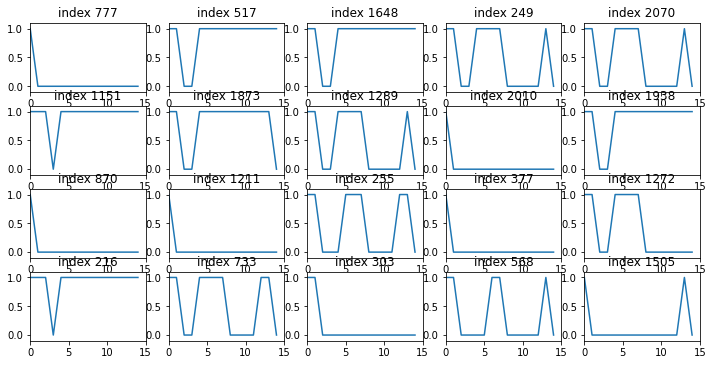

In [17]:
ctl=docume_ctl[1,:,:] # t=1 the independent repetition
# print(ctl.shape)
plt.figure(figsize=(12,15))
for i in range(20): # i ranges over the distinctive images , not the index
    #print(ctl[i,1,:]) # 1 is the classification data , 0 would be the index
    plt.subplot(10, 5, i+1)
    plt.axis((0,num_epochs,-0.1,1.1))
    plt.title('index {}'.format(ctl[i,0,0]))
    plt.plot(ctl[i,1,:])
    #ctl[ctl.columns[i]].plot()
# plt.savefig(docume_dir_named+'oscillation.png')

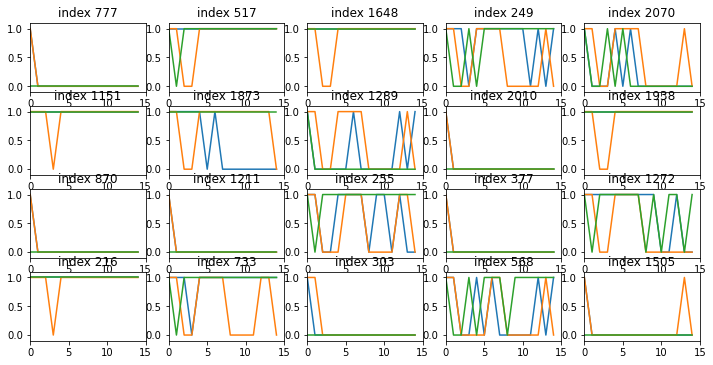

In [18]:
plt.figure(figsize=(12,15))
for i in range(20): # i ranges over the distinctive images , not the index
    #print(ctl[i,1,:]) # 1 is the classification data , 0 would be the index
    plt.subplot(10, 5, i+1)
    plt.axis((0,num_epochs,-0.1,1.1))
    plt.title('index {}'.format(docume_ctl[0,i,0,0]))
    plt.plot(docume_ctl[:,i,1,:].T)
    #ctl[ctl.columns[i]].plot()
# plt.savefig(docume_dir_named+'oscillation.png')

# check if they really belong together, if the index is constant for all the data that goes into a single plot. Know what I mean?

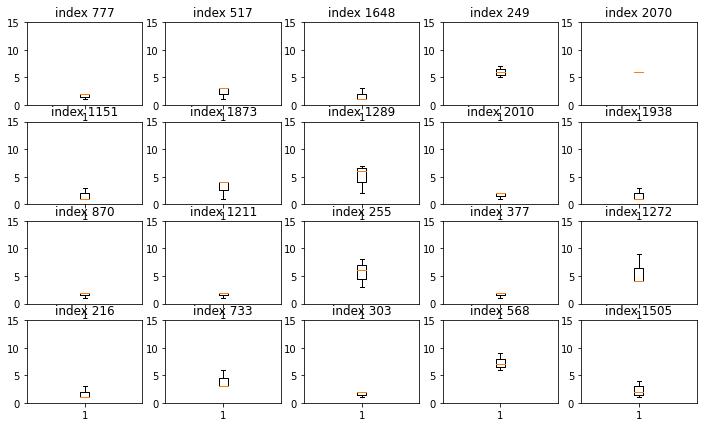

In [19]:
# transform 100 line plots into a bar chart
# for each line plot count the numbers of changes (about twice the number of peaks (2 changes = 1 peak or valley))

#create a pandas
df = pd.DataFrame(docume_ctl[0,:,0,0])
# visualize
plt.figure(figsize=(12,7))
for i in range(20):
    a = docume_ctl[:,i,1,:] # 2 dim , flat,; row for repetiton, column for epoch
    plt.subplot(4, 5, i+1)
    b=[num_epochs-[a[j,k+1]-a[j,k] for k in range(num_epochs-1)].count(0) for j in range(a.shape[0])]
    #print(b)
    plt.boxplot(b)
    plt.axis((0,2,0,num_epochs))
    plt.title('index {}'.format(docume_ctl[0,i,0,0]))
plt.show()

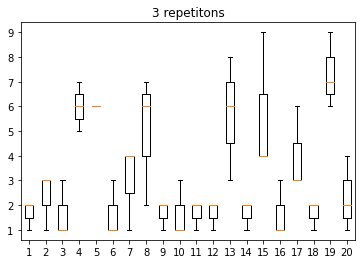

In [115]:
#create a pandas 
# create the index of rows , the index in the dataloader
df = pd.DataFrame({'index': docume_ctl[0,:,0,0]}).set_index('index')
# print(docume_ctl.shape)
#create columns, one for each repetition (Dont use T, because some repetitons were removed (algo did not learn))
for t in range(docume_ctl.shape[0]):
    df[str(t)]= 0
#print(df)
# print(df.shape)

for i in range(docume_ctl.shape[1]): # loop through images (via their index, as in labels_i, labels['index'] returned by dataloader)
    a = docume_ctl[:,i,1,:] # 2 dim , flat,; row for repetiton, column for epoch, contains the classifications
    b=[num_epochs-[a[j,k+1]-a[j,k] for k in range(num_epochs-1)].count(0) for j in range(a.shape[0])] # num_epochs - nr of epochs when the classification did not change
    # print(b)
    df.iloc[i]=b
# print(df.iloc[0:20])
# visualize

plt.title('{} repetitons'.format(docume_ctl.shape[0]))
plt.boxplot(df.iloc[0:20])
# draw index as xlabel
# plt.xticks([range(20)], docume_ctl[0,0:20,0,0], size='small')
# plt.xticks(ticks=list(range(20)),labels=list(df.index[0:20]))

plt.show()

In [144]:
''' not visual enough... but this could lead to a statistical test...
# check the sd in the number of changes per image
# this should give a similar answer as the mean ofer the pecm (%epochs classified male)
# Are images consistantly oscillating ? or (seemingly) randomly oscillating?
for i in range(20): # i ranges over the distinctive images , not the index
    stds = np.std(docume_ctl[:,i,1,:].T, axis = 0)
    #print(docume_ctl[:,i,1,:].T.shape , stds.shape)
    print('standard deviations over all the epochs of a repetition / train - val cycle for num_epochs:\n', np.round(stds,3))
    print('Mean of standard deviations:\n', round(np.mean(stds),3))
    print('Standard deviation of standard deviations:\n', round(np.std(stds),3),'\n')
'''

" not visual enough... but this could lead to a statistical test...\n# check the sd in the number of changes per image\n# this should give a similar answer as the mean ofer the pecm (%epochs classified male)\n# Are images consistantly oscillating ? or (seemingly) randomly oscillating?\nfor i in range(20): # i ranges over the distinctive images , not the index\n    stds = np.std(docume_ctl[:,i,1,:].T, axis = 0)\n    #print(docume_ctl[:,i,1,:].T.shape , stds.shape)\n    print('standard deviations over all the epochs of a repetition / train - val cycle for num_epochs:\n', np.round(stds,3))\n    print('Mean of standard deviations:\n', round(np.mean(stds),3))\n    print('Standard deviation of standard deviations:\n', round(np.std(stds),3),'\n')\n"

In [ ]:
# do simulations: 
# * if images oscilate randomly (over epochs and repetitions)
# * if images fall in 2 classes of high vs low probability to oscillate

777 983.jpg
777
0    777
Name: 0, dtype: int16


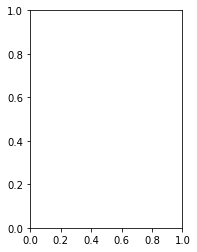

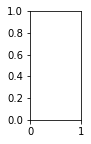

517 400.jpg
517
0    777
Name: 0, dtype: int16


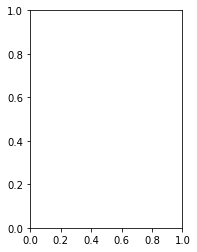

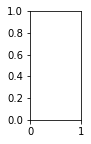

1648 2105.jpg
1648
0    777
Name: 0, dtype: int16


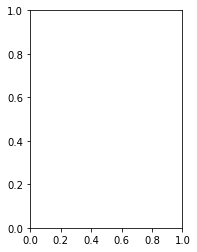

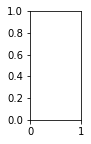

249 401.jpg
249
0    777
Name: 0, dtype: int16


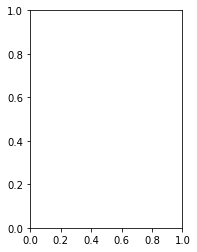

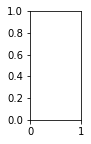

2070 1110.jpg
2070
0    777
Name: 0, dtype: int16


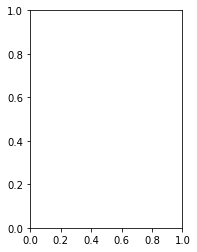

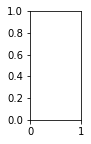

1151 217.jpg
1151
0    777
Name: 0, dtype: int16


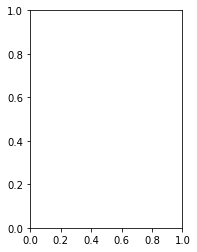

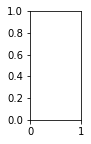

1873 586.jpg
1873
0    777
Name: 0, dtype: int16


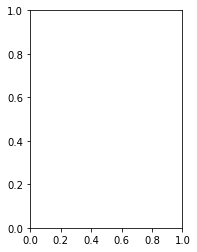

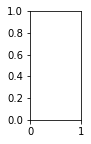

1289 833.jpg
1289
0    777
Name: 0, dtype: int16


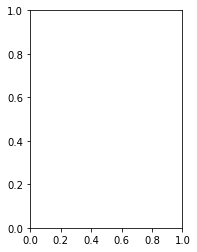

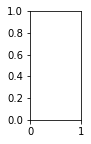

2010 282.jpg
2010
0    777
Name: 0, dtype: int16


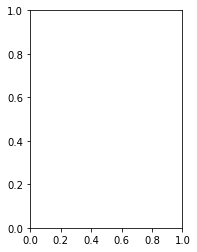

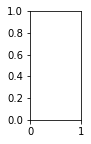

1938 912.jpg
1938
0    777
Name: 0, dtype: int16


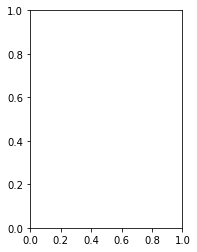

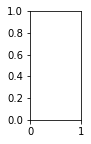

870 176.jpg
870
0    777
Name: 0, dtype: int16


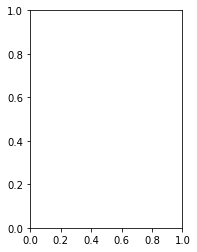

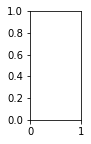

1211 1997.jpg
1211
0    777
Name: 0, dtype: int16


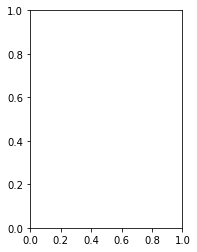

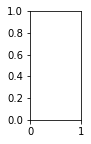

255 1016.jpg
255
0    777
Name: 0, dtype: int16


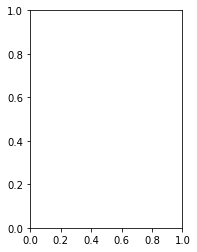

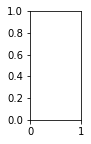

377 1585.jpg
377
0    777
Name: 0, dtype: int16


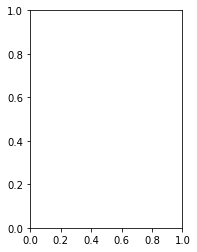

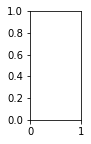

1272 816.jpg
1272
0    777
Name: 0, dtype: int16


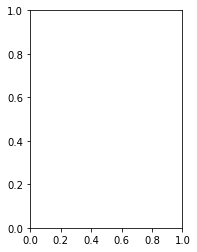

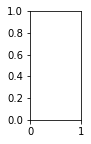

216 946.jpg
216
0    777
Name: 0, dtype: int16


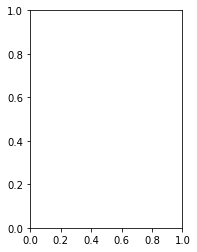

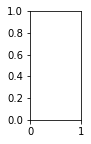

733 1357.jpg
733
0    777
Name: 0, dtype: int16


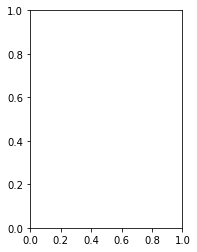

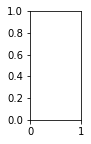

303 562.jpg
303
0    777
Name: 0, dtype: int16


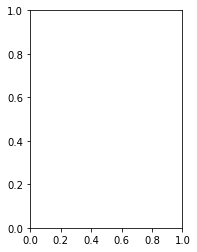

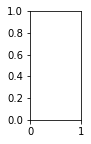

568 539.jpg
568
0    777
Name: 0, dtype: int16


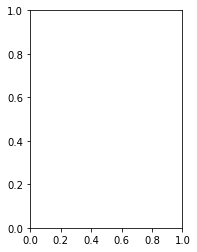

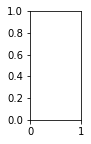

1505 187.jpg
1505
0    777
Name: 0, dtype: int16


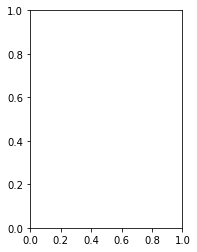

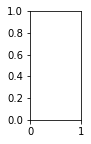

In [37]:
with torch.no_grad():
    for img, lab in val_loader.dataset:
        print('the labels : ' , lab['index'],lab['file'])
        # subplot 1 : the image
        plt.subplot(121)
        #plt.figure(figsize=(2, 2))
        plt.imshow(img.permute(1,2,0))
        plt.axis('off')
        # subplot 2 : the oscillation
        #print(lab['index'])
        #print(df.iloc[0])
        plt.subplot(122)
        plt.boxplot(list(df.loc[int(lab['index'])]))
        plt.axis((0,2,0,num_epochs))
        plt.show()

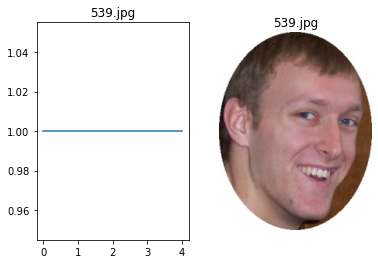

In [36]:
# show the oscillations and the image.
# does the eye / brain catch a pattern, here?
# Which image oscillates? which is easily / consistently classified?

# is there a pattern when adding info about correct classification at a 
# (estimated early or the best models actual??) stopping time?

n=18
plt.subplot(121)
plt.plot(ctl[ctl.columns[n]])
plt.title(ctl.columns[n])
plt.subplot(122)
img = PIL.Image.open(images_train_dir+ctl.columns[n])
plt.imshow(img)#.permute(1,2,0))
plt.title(ctl.columns[n])
plt.axis('off')
plt.show()

In [38]:
osc=[[],[],[]] # oscillation
for fn in ctl.columns:
    ct_1 = [ctl[fn][i+1] - ctl[fn][i] for i in range(num_epochs-1)].count(1) # count 1's
    if ct_1 >6:
        osc[2].append(fn)
    elif ct_1 >1:
        osc[1].append(fn)
    else:
        osc[0].append(fn)
len(osc[0]), len(osc[1]), len(osc[2])

(100, 0, 0)

Images with high oscilation

## classification timelines grouped by correct classification vs misclassification

In [39]:
# accessing information through the data loader
dict1 = {}
print(len(val_loader))
for img, lab in val_loader.dataset:
    dict1[lab['file']]=lab['gender']
g = pd.DataFrame.from_dict(dict1, orient='index', columns=['gender'])

10


I do not see a similarity in the images with no/1 or many oscillations. And I don't see a difference b/w the groups.

Now we should see, if the oscillation is concentrated on a subset of images or if it is randomly spread over the validation set.

We have to compare the number of oscillations over the repetitions. 

1. mean number of (highly) oscillating images per repetition.

2. sd of number of (highly) oscillating images per repetition

3. Statistical test: is there an underlying true number of (highly) oscillating images or is the number of (highly) oscillating images per repetition a random number.

4. Are there images that oscillate in many / all repetitions? Is the oscillation of an image a property / charcteristic or just random noise? Are there vulnerable images? Is vulnerability related to gender or ethnicity labels?

5. is vulnerability related to misclassification? Or independent thereof?

In [40]:
ctl.sum(axis=1) / len(val_loader.dataset) # proportion of classified male for the epochs
# first 5 (say...) epochs should be removed from analysis.

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
dtype: float64

In [21]:
ctl.sum(axis=1) / len(val_loader.dataset) # proportion of classified male for the epochs
# first 5 (say...) epochs should be removed from analysis.
ctl_after_wup = ctl.copy() # classification timeline after wup : warm up
wup_epochs = 5
ctl_after_wup = ctl[wup_epochs:]
print(ctl_after_wup.shape)

(45, 100)


pecm    0.092593
cese    0.000000
dtype: float64 pecm    0.936782
cese    1.000000
dtype: float64


,pecm,cese
983.jpg,0.000000,0
400.jpg,1.000000,1
2105.jpg,1.000000,1
401.jpg,0.866667,1
1110.jpg,0.133333,0
...,...,...
327.jpg,0.355556,0
421.jpg,0.555556,0
813.jpg,0.000000,0
1190.jpg,0.022222,0


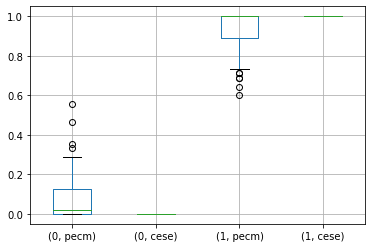

In [24]:
df = pd.DataFrame(ctl_after_wup.sum(axis=0) / ctl_after_wup.shape[0], columns=['pecm']) # proportion of epochs when classified male
df['cese'] = pd.DataFrame(ctl_after_wup.iloc[est_early_stop_time-wup_epochs]) # classification at estimated stopping epoch
print(df[df['cese']==0].mean() ,df[df['cese']==1].mean())
#print('mean :\n' , b.groupby('cese').mean(), '\nmedian :\n' , b.groupby('cese').median())
df.groupby('cese').boxplot('pecm')
df

In [25]:
df['gender'] = g
df['cese correct'] = (df['cese'] == df['gender']).astype(int)
df

,pecm,cese,gender,cese correct
983.jpg,0.000000,0,0,1
400.jpg,1.000000,1,1,1
2105.jpg,1.000000,1,1,1
401.jpg,0.866667,1,1,1
1110.jpg,0.133333,0,0,1
...,...,...,...,...
327.jpg,0.355556,0,0,1
421.jpg,0.555556,0,1,0
813.jpg,0.000000,0,0,1
1190.jpg,0.022222,0,0,1


In [79]:
oscil=dict()
n=ctl_after_wup.shape[0]
print(ctl_after_wup.shape)
for idx in range(ctl_after_wup.shape[1]): # idx in 0 ... 99
    fn=ctl_after_wup.columns[idx]  # the file name
    oscil[fn]= n - [ctl_after_wup.iloc[k+1][idx]-ctl_after_wup.iloc[k][idx] for k in range(ctl_after_wup.shape[0]-1)].count(0)
df = pd.DataFrame.from_dict(oscil, orient='index', columns=['oscil'])
df

(45, 100)


,oscil
983.jpg,1
400.jpg,1
2105.jpg,1
401.jpg,7
1110.jpg,4
...,...
327.jpg,10
421.jpg,22
813.jpg,1
1190.jpg,2


In [49]:
print(docume_ctl[0])
oscil=dict()
print('n : ' , n)
n,m = ctl.shape
for t in range(len(docume_ctl)):
    ctl = docume_ctl[t].T
    print(type(ctl))
    for idx in range(ctl.shape[1]): # idx in 0 ... 99
        fn=ctl.columns[idx]  # the file name
        oscil[fn]= n - [ctl.iloc[k+1][idx]-ctl.iloc[k][idx] for k in range(ctl.shape[0]-1)].count(0)
        if t == 0:
            df = pd.DataFrame.from_dict(oscil, orient='index', columns=['oscil'])
        else:
            df= df.append(pd.DataFrame.from_dict(oscil, orient='index'),ignore_index=True)
    
df

#plt.title(ctl.columns[i])
#    plt.plot(ctl[ctl.columns[i]])

          0  1  2  3  4
983.jpg   1  1  1  1  1
400.jpg   1  1  1  1  1
2105.jpg  1  1  1  1  1
401.jpg   1  1  1  1  1
1110.jpg  1  1  1  1  1
...      .. .. .. .. ..
327.jpg   1  1  1  1  1
421.jpg   1  1  1  1  1
813.jpg   1  1  1  1  1
1190.jpg  1  1  1  1  1
158.jpg   1  1  1  1  1

[100 rows x 5 columns]
n :  5
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


,0,oscil
0,NaN,1.0
1,NaN,1.0
2,NaN,1.0
3,NaN,1.0
4,NaN,1.0
...,...,...
10095,1.0,NaN
10096,3.0,NaN
10097,2.0,NaN
10098,2.0,NaN


In [80]:
print(docume_ctl)

[[[1. 1. 1. ... 1. 1. 1.]
  [0. 1. 1. ... 0. 0. 0.]
  [0. 1. 1. ... 0. 0. 0.]
  ...
  [0. 1. 1. ... 0. 0. 1.]
  [0. 1. 1. ... 0. 0. 0.]
  [0. 1. 1. ... 0. 0. 1.]]

 [[1. 1. 1. ... 0. 1. 1.]
  [0. 1. 1. ... 0. 1. 1.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 1. 1. ... 0. 0. 1.]
  [0. 1. 1. ... 0. 0. 0.]
  [0. 1. 1. ... 0. 0. 1.]]

 [[0. 1. 1. ... 0. 1. 1.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 1. 1. ... 0. 0. 0.]
  ...
  [0. 1. 1. ... 0. 0. 0.]
  [0. 1. 1. ... 0. 0. 1.]
  [0. 1. 1. ... 0. 0. 0.]]]


In [40]:
ctl_after_wup.columns[0]

'983.jpg'

## other stuff

In [ ]:
# add oscillation count, it may serve as a confidence metric for the classification
# add repetitions and take the sd / standard deviation of the oscillation and cese correct
# are there vulnerable images?

# works , but we don't need this
# we already have the information aggregated in pecm
df2 = df.join(ctl.T)
df2

In [40]:
setup1= setup.set_index('newFilename', drop=True)
setup1 = pd.concat([setup1, a], axis=1, join='inner')

In [41]:
# pecc : percentage of epochs correctly classified : 
# if gender ==1 then pecc=pecm
# if gender ==0 then pecc=1-pecm

# should work with fc as classification of the selected and fixed / saved model

# add oscillation count, it may serve as a confidence metric for the classification

In [38]:
setup1.sort_values('pecm')

,Gender,Age,Race,fc,pecm
432.jpg,0,2.833333,1,0,0.8
985.jpg,1,4.333333,1,0,0.8
813.jpg,0,4.250000,1,0,0.8
569.jpg,0,2.166667,1,0,0.8
1752.jpg,0,3.083333,2,0,0.8
...,...,...,...,...,...
1357.jpg,1,4.750000,1,1,1.0
214.jpg,1,3.250000,1,1,1.0
594.jpg,1,2.750000,5,1,1.0
2111.jpg,1,4.083333,1,1,1.0


In [39]:
setup1.to_csv('mod3_20epochs.csv', header=True, index=False)

Add a variable correct classification and make a logistic regression on the validation set.
This tells us how much race, age and gender contribute to a correct classification.